In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import *
from qiskit.quantum_info import state_fidelity
# Numpy and Scipy for data evaluation and reference calculations
import numpy as np
from scipy.linalg import expm
# Matplotlib for visualization
import matplotlib.pyplot as plt
# Magic function to render plots in the notebook after the cell executing the plot command
%matplotlib inline

In [2]:
# Function for convenience which allows for running the simulator and extracting the results
def run_on_qasm_simulator(quantum_circuit, num_shots):
    """Takes a circuit, the number of shots and a backend and returns the counts for running the circuit
    on the qasm_simulator backend."""
    qasm_simulator = Aer.get_backend('qasm_simulator')
    job = execute(quantum_circuit, backend=qasm_simulator, shots=num_shots)
    result = job.result()
    counts = result.get_counts()
    return counts

In [3]:
def Op(M, n ,N):
    """Given a single site operator, provide the N-body operator 
    string obtained by tensoring identities"""
    d = M.shape[0]
    id_left = np.eye(d**n)
    id_right = np.eye(d**(N-n-1))
    res = np.kron(id_left,np.kron(M,id_right))
    return res

def IsingHamiltonian(N, h):
    """The Ising Hamiltonian for N sites with parameter h"""
    Z = np.array([[1., 0.],[0., -1.]])
    X = np.array([[0., 1.],[1., 0.]])
    H = np.zeros((2**N, 2**N))
    for i in range(N):
        if i<N-1:            
            H += Op(Z, i, N)@Op(Z, i+1, N)
        H += h*Op(X, i, N)
    return H            

# For reference, we provide a function computing the exact solution for
# the magnetization as a function of time
def get_magnetization_vs_time(h, delta_t, nsteps):
    """Compute the exact value of the magnetization"""
    Z = np.array([[1., 0.],[0., -1.]])
    X = np.array([[0., 1.],[1., 0.]])
    Id = np.eye(2)
    # The Ising Hamiltonian for 4 sites with parameter h
    H = IsingHamiltonian(4, h)
    # The time evolution operator for an interval \Delta t
    U = expm(-1.0j*delta_t*H)
    # The operator for the total magnetization
    M = Op(Z,0,4) + Op(Z,1,4) + Op(Z,2,4) + Op(Z,3,4)
    # Numpy array to hold the results
    magnetization = np.zeros(nsteps)
    # The initial wave function corresponding to |0010>
    psi = np.zeros(16)
    psi[int('0010', 2)] = 1
    # Evolve in steps of \Delta t and measure the magnetization
    for n in range(nsteps):
        psi = U@psi
        magnetization[n] = np.real(psi.conj().T@M@psi)
    return magnetization

In [4]:
def provide_initial_state():
    # Create a quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    # Add the necessary gate(s) to provide the inital state |0010>
    qc.x(1)
    
    return qc

In [28]:
def Uzz(delta_t):
    # Create an empty quantum circuit qc for 4 qubits
    Nqubits = 4
    qc = QuantumCircuit(Nqubits)
    # Add the gates for exp(-i Z_k Z_k+1 \Delta t) for all neighboring qubits
    for iq in range(Nqubits-1):
        qc.rzz(2*delta_t,iq,iq+1)
    
    return qc

In [29]:
def Ux(delta_t, h):
    # Create an empty quantum circuit qc for 4 qubits
    Nqubits = 4
    qc = QuantumCircuit(Nqubits)
    # Add the gates for exp(-i h X_k \Delta t) to all qubits
    for iq in range(Nqubits):
        qc.rx(2*delta_t*h,iq) # RX(theta) = exp(-i theta X/2)
    
    return qc

In [30]:
def build_time_evolution_circuit(qc_init_state, qc_Uzz, qc_Ux, N):
    """Given the circuits implementing the initial state and the two parts
    of the trotterized time-evolution operator build the circuit evolving the 
    wave function N steps
    """
    # Generate an empty quantum circuit qc for 4 qubits
    qc = QuantumCircuit(4)
    # Add the inital state
    qc.compose(qc_init_state,inplace=True)
    # For each time step add qc_Uzz and qc_Ux
    for i in range(N):
        qc.compose(qc_Uzz,inplace=True)
        qc.compose(qc_Ux,inplace=True)
    # Add the final measurments
    qc.measure_all()
    qc.draw()
    return qc

In [31]:
def get_magnetization(counts):
    """Given the counts resulting form a measurement, compute the site
    resolved magnetization"""
    total_counts = sum(counts.values())
    res = np.zeros(4)
    for qubit in range(4):
        Z_expectation = 0.
        for key, value in counts.items():
            if key[qubit] == '0':
                Z_expectation += value
            else:
                Z_expectation -= value
        res[qubit] = Z_expectation/total_counts
    return res

In [52]:
# The parameters for the time evolution
h = 1.5
delta_t = 0.2
nsteps = 50
nshots = 1000

# Provide the initial state
qc_init_state = provide_initial_state()
# The time-evolution operators
qc_Uzz = Uzz(delta_t)
qc_Ux = Ux(delta_t, h)

In [53]:
# Numpy array for expectation values of the magnetization
magnetization = np.zeros(nsteps)
# Numpy array for qubit configuration
configuration = np.zeros((4, nsteps))
# Run the time evolution
for n in range(1, nsteps+1):
    # Build the evolution circuit out of qc_init_state, qc_Uzz and qc_Ux for 
    # n steps
    qc_evo = build_time_evolution_circuit(qc_init_state, qc_Uzz, qc_Ux, n)
    # Run the evolution circuit on the qasm_simulator
    res = run_on_qasm_simulator(qc_evo, nshots)
    # Compute the ovservables
    configuration[:,n-1] = get_magnetization(res)    
    magnetization[n-1] = sum(configuration[:,n-1])
# For reference we compute the exact solution
magnetization_exact = get_magnetization_vs_time(h, delta_t, nsteps)

Text(0.5, 1.0, 'Spatially resolved spin configuration')

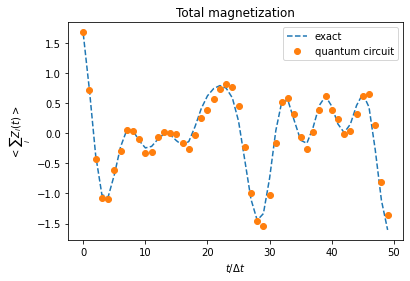

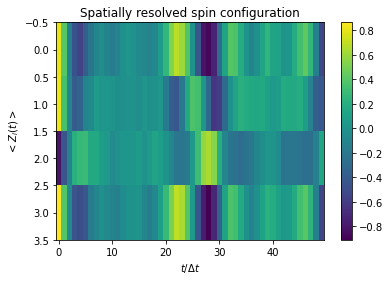

In [54]:
# Plot the total magnetization as a function of time and compare to
# the exact result
plt.figure()
plt.plot(magnetization_exact, '--', label='exact')
plt.plot(magnetization, 'o', label='quantum circuit')
plt.xlabel('$t/\Delta t$')
plt.ylabel('$<\sum_i Z_i(t)>$')
plt.title('Total magnetization')
plt.legend()

# Plot the site resolved spin configuration as a function of time
plt.figure()
plt.imshow(configuration, aspect='auto')
plt.colorbar()
plt.xlabel('$t/\Delta t$')
plt.ylabel('$<Z_i(t)>$')
plt.title('Spatially resolved spin configuration')